<center> <img src = https://avatars.dzeninfra.ru/get-zen_doc/1594475/pub_5f9fcaa79ac0705ae47ee8db_5f9fe3c91f9f73799251bad0/scale_1200 alt="drawing" style="width:800px;">

# <center> Проект: Прогнозирование длительности поездки на такси в Нью-Йорке

## 1. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
plt.style.use('seaborn')

C:\Users\Андрей\AppData\Local\Temp\ipykernel_5912\1648308351.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Прочитаем наш файл с исходными данными:

In [2]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки на несколько групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### 1.1 Анализ временного признака
Посмотрим на временные рамки, в которых мы работаем с данными.

Переведем признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() используем параметр format='%Y-%m-%d %H:%M:%S'). 

Определим временные рамки (без учета времени), за которые представлены данные.

In [3]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
min_date = taxi_data['pickup_datetime'].dt.date.min()
max_date = taxi_data['pickup_datetime'].dt.date.max()
print(f'Данные представлены за период: с {min_date} по {max_date}.')

Данные представлены за период: с 2016-01-01 по 2016-06-30.


### 1.2 Анализ пропущенных значений
Определим количество пропущенных значений в данных (суммарно по всем столбцам таблицы)?

In [4]:
print(f'Количество пропусков суммарно по всем столбцам таблицы: {taxi_data.isnull().sum().sum()}.')

Количество пропусков суммарно по всем столбцам таблицы: 0.


### 1.3 Анализ статистических характеристик
Посмотрим на статистические характеристики некоторых признаков. 

In [5]:
print('Количество уникальных таксопарков:', taxi_data['vendor_id'].nunique())
print('Максимальное количество пассажиров:', taxi_data['passenger_count'].max())
print('Средняя длительность поездки: {} сек.'.format(taxi_data['trip_duration'].mean().round())) 
print('Медианная длительность поездки: {} сек.'. format(taxi_data['trip_duration'].median().round()))
print('Минимальное время поездки: {} сек.'.format(taxi_data['trip_duration'].min()))
print('Максимальное время поездки: {} сек.'.format(taxi_data['trip_duration'].max()))

Количество уникальных таксопарков: 2
Максимальное количество пассажиров: 9
Средняя длительность поездки: 959.0 сек.
Медианная длительность поездки: 662.0 сек.


Минимальное время поездки: 1 сек.
Максимальное время поездки: 3526282 сек.


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### 1.4 Добавление новых признаков из признака "pickup_date"
Реализем функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

In [6]:
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.day_name(locale='en_US.utf8')
    return df

add_datetime_features(taxi_data)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,Friday
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,Sunday
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,Friday
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,Tuesday


In [7]:
# количество поездок по дням недели
display(taxi_data.groupby('pickup_day_of_week')['pickup_day_of_week'].count())
# среднее количество поездок
trip_mean = taxi_data.groupby('pickup_date')['pickup_date'].count().mean()
print(f'Среднее количество поездок в день: {trip_mean.round()}')

pickup_day_of_week
Friday       223533
Monday       187418
Saturday     220868
Sunday       195366
Thursday     218574
Tuesday      202749
Wednesday    210136
Name: pickup_day_of_week, dtype: int64

Среднее количество поездок в день: 8015.0


### 1.5 Добавление признака "pickup_holiday"
Реализуем функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

In [8]:
# проичтаем данные с праздничными днями
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')
# выполним функцию
def add_holiday_features(trip_df, holiday_df):
    holiday_df['date'] = pd.to_datetime(holiday_df['date']).dt.date
    holiday_list = list(holiday_data['date'].unique())
    trip_df['pickup_holiday'] = trip_df['pickup_date'].apply(lambda x: 1 if x in holiday_list else 0)
    return trip_df
add_holiday_features(taxi_data, holiday_data).head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,0


### 1.5 Работаем с географическими характеристиками
Реализуем функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

In [10]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')
osrm_data.head()

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."
3,id2181028,Broadway,West 81st Street,1614.9,140.1,5,Broadway|West 86th Street|Columbus Avenue|West...,617|427.4|412.2|158.3|0,56|36|37.8|10.3|0,depart|turn|turn|turn|arrive,right|left|right|left|arrive,"-73.972998,40.793187|-73.976607,40.788361|-73...."
4,id0801584,Lexington Avenue,West 31st Street,1393.5,189.4,5,Lexington Avenue|East 27th Street|Madison Aven...,18.9|311.9|313.3|749.4|0,6.3|42.9|48.4|91.8|0,depart|turn|turn|turn|arrive,right|right|right|left|arrive,"-73.982805,40.742173|-73.982914,40.742024|-73...."


Нас будут интересовать только следующие столбцы:

* *id* — идентификатор поездки;
* *total_distance* — кратчайшее дорожное расстояние (в метрах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
* *total_travel_time* — наименьшее время поездки (в секундах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
* *number_of_steps* — количество дискретных шагов, которые должен выполнить водитель (поворот налево/поворот направо/ехать прямо и т. д.).

In [11]:
def add_osrm_features(trip, osrm):
    # osrm_new = osrm[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
    taxi_merged = trip.merge(osrm[['id', 'total_distance', 'total_travel_time', 'number_of_steps']], on='id', how='left')
    return taxi_merged
taxi_data = add_osrm_features(taxi_data, osrm_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,0,2009.1,164.9,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,0,2513.2,332.0,6.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,0,1779.4,235.8,4.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,0,1614.9,140.1,5.0


В результате объединения таблиц у нас появились пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

In [13]:
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

Если рассматривать Землю как сферу, то, зная широту и долготу начальной и конечной точек маршрута, можно вычислить географическое расстояние между точками на сфере, а также узнать направление движения автомобиля.
Воспользуемся следующими функциями:

* *get_haversine_distance* — функция для вычисления расстояния по формуле гаверсинуса (в километрах);
* *get_angle_direction* — функция для вычисления угла направления движения (в градусах).
Каждая из функций имеет четыре аргумента:

*lat1* и *lng1* — векторы-столбцы с широтой и долготой первой точки;
*lat2* и *lng2* — векторы-столбцы с широтой и долготой второй точки.

In [14]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

Реализуем функцию `add_geographical_features()`, которая принимает на вход таблицу с данными о поездках и возвращает обновлённую таблицу с добавленными в неё двумя столбцами:

* *haversine_distance* — расстояние по формуле гаверсинуса между точкой, в которой был включён счетчик, и точкой, в которой счётчик был выключен;
* *direction* — направление движения из точки, в которой был включён счётчик, в точку, в которой счётчик был выключен.  

Применим полученную функцию к таблице.


In [15]:
def add_geographical_features(taxi_data):
    taxi_data['haversine_distance'] = taxi_data.apply(
        lambda row: get_haversine_distance(
            row['pickup_latitude'],
            row['pickup_longitude'],
            row['dropoff_latitude'],
            row['dropoff_longitude']),
        axis=1)
    taxi_data['direction'] = taxi_data.apply(
        lambda row: get_angle_direction(
            row['pickup_latitude'],
            row['pickup_longitude'],
            row['dropoff_latitude'],
            row['dropoff_longitude']),
        axis=1)
    return taxi_data

In [16]:
add_geographical_features(taxi_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,0,2009.1,164.9,5.0,1.498521,99.970196
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,0,2513.2,332.0,6.0,1.805507,-117.153768
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0,6.385098,-159.680165
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,0,1779.4,235.8,4.0,1.485498,-172.737700
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,0,1614.9,140.1,5.0,1.188588,179.473585


Применим кластеризацию по географическим координатам. Идея заключается в том, чтобы сгруппировать все поездки в зависимости от координат начала и конца поездки с помощью методов кластеризации, тем самым добавив информацию о районах, в которых находятся точки старта и конца поездки.

Гипотеза состоит в том, что длительность поездки будет зависеть от того, к какому географическому кластеру будет принадлежать поездка.  

В качестве метода кластеризации воспользуемся алгоритмом *K-Means*. Возьмём десять кластеров и обучим его на данных, сформированных из широты и долготы всех точек начала и конца поездок.
  
Реализуем функцию `add_cluster_features()`, которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом *geo_cluster* - географический кластер, к которому относится поездка.

In [17]:
# алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)

def add_cluster_features(trip_df, kmeans):
    # создаем обучающую выборку из географических координат всех точек
    coords = np.hstack((trip_df[['pickup_latitude', 'pickup_longitude']],
                        trip_df[['dropoff_latitude', 'dropoff_longitude']]))
    # обучаем алгоритм кластеризации
    kmeans.fit(coords)
    trip_df['geo_claster'] = kmeans.predict(coords)
    return trip_df

add_cluster_features(taxi_data, kmeans)

h:\DataScience\programs\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction,geo_claster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,17,Monday,0,2009.1,164.9,5.0,1.498521,99.970196,9
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,0,Sunday,0,2513.2,332.0,6.0,1.805507,-117.153768,4
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0,6.385098,-159.680165,4
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,19,Wednesday,0,1779.4,235.8,4.0,1.485498,-172.737700,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,13,Saturday,0,1614.9,140.1,5.0,1.188588,179.473585,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,2016-04-08,13,Friday,0,2234.6,311.7,8.0,1.225080,-119.059338,0
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,2016-01-10,7,Sunday,0,7638.0,589.6,11.0,6.049836,25.342196,9
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,2016-04-22,6,Friday,0,9871.5,642.9,10.0,7.824606,-150.788492,4
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,2016-01-05,15,Tuesday,0,1628.3,161.6,7.0,1.092564,35.033294,0


In [18]:
# количество поездок по кластерам
taxi_data['geo_claster'].value_counts().sort_values()

2         2
8         5
6        18
1      7233
3     27022
7     41171
5     43619
4    359233
9    383874
0    596467
Name: geo_claster, dtype: int64

### 1.6 Работаем с характеристиками погоды
Реализуеме функцию `add_weather_features()`, которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* *temperature* - температура;
* *visibility* - видимость;
* *wind speed* - средняя скорость ветра;
* *precip* - количество осадков;
* *events* - погодные явления.

In [19]:
weather_data = pd.read_csv('data/weather_data.csv')

def add_weather_features(trip_df, weaher_df):
    weaher_df['time'] = pd.to_datetime(weaher_df['time'])
    weaher_df['pickup_date'] = weaher_df['time'].dt.date
    weaher_df['pickup_hour'] = weaher_df['time'].dt.hour
    trip_df = trip_df.merge(weaher_df[[
    'pickup_date',
    'pickup_hour',
    'temperature',
    'visibility',
    'wind speed',
    'precip',
    'events']], on=['pickup_date', 'pickup_hour'], how='left')
    return trip_df
taxi_data = add_weather_features(taxi_data, weather_data)

In [23]:
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,geo_claster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None


## 2. Обработка пропусков, очистка данных

### 2.1 Замена пропущенных значений

Теперь, когда мы расширили датасет новыми признаками, нам необходимо немного его подчистить.  

* В результате добавления новой информации у нас появились пропущенные значения в данных.
* Благодаря новым добавленным признакам мы сможем более детально изучить поездки с аномальной длительностью.

Реализуем функцию `fill_null_weather_data`(), которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  *temperature*, *visibility*, *wind speed*, *precip* заполним медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируем данные по столбцу *pickup_date* и рассчитаем медиану в каждой группе, после чего с помощью комбинации методов `transform()` и `fillna()` заполним пропуски. 
Пропуски в столбце *events* заполним строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - *total_distance*, *total_travel_time* и *number_of_steps* заполним медианным значением по столбцам. 

In [24]:
def fill_null_weather_data(trip_df):
    weather_features = ['temperature', 'visibility', 'wind speed', 'precip']
    for feature in weather_features:
        trip_df[feature] = trip_df[feature].fillna(trip_df.groupby('pickup_date')[feature].transform('median'))
    trip_df['events'] = trip_df['events'].fillna('None')
    osrm_features = ['total_distance', 'total_travel_time', 'number_of_steps']
    for feature in osrm_features:
        trip_df[feature] = trip_df[feature].fillna(trip_df[feature].median())
    return trip_df
fill_null_weather_data(taxi_data)    

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,geo_claster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,311.7,8.0,1.225080,-119.059338,0,7.8,16.1,11.1,0.0,None
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,589.6,11.0,6.049836,25.342196,9,7.2,2.8,18.5,8.1,Rain
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,642.9,10.0,7.824606,-150.788492,4,18.3,16.1,0.0,0.0,None
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,161.6,7.0,1.092564,35.033294,0,-2.8,16.1,9.3,0.0,None


### 2.2 Удаление выбросов

Найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. 

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:

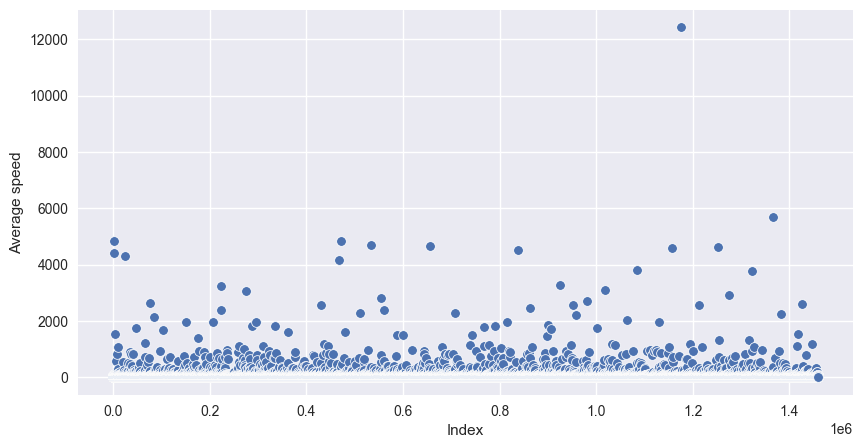

In [26]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


Найдем поездки, длительность которых превышает 24 часа. И удалим их из набора данных.

In [27]:
outliers_duration = taxi_data[taxi_data['trip_duration'] > 86400]
taxi_data.drop(outliers_duration.index, axis=0, inplace=True)

Найдем поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалим их из данных. 

In [28]:
mask = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
outliers_speed = taxi_data[mask > 300]
taxi_data.drop(outliers_speed.index, axis=0, inplace=True)

## 3. Разведывательный анализ данных (EDA)

В этой части проекта:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими исследование. 

Начинаем с целевого признака. Основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [29]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### 3.1 Диаграмма длительности поездки
Построим гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Проверим гипотезу о нормальности распределения с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

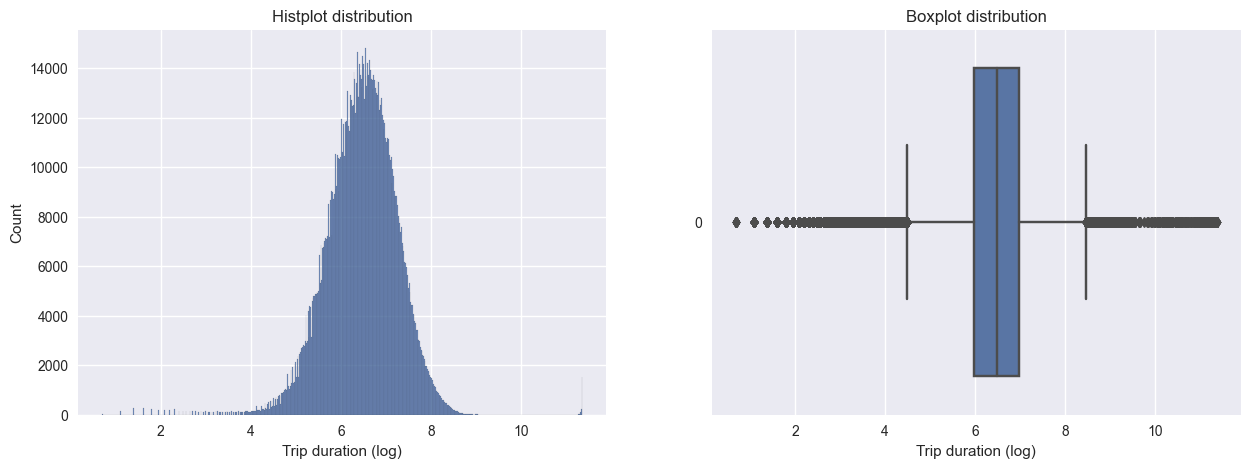

In [30]:
# построение диаграмм
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(taxi_data['trip_duration_log'], ax=axes[0])
axes[0].set_xlabel('Trip duration (log)')
axes[0].set_title('Histplot distribution')
sns.boxplot(taxi_data['trip_duration_log'], orient='h', ax=axes[1])
axes[1].set_xlabel('Trip duration (log)')
axes[1].set_title('Boxplot distribution');

In [31]:
# проверка гипотезы о нормальности рапсределения
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально.Отвергаем нулевую гипотезу'
alpha = 0.05

_, p = stats.normaltest(taxi_data[['trip_duration_log']])
print(p[0])

if p[0] > alpha/2:
    print(H0)
else:
    print(Ha)


0.0
Данные не распределены нормально.Отвергаем нулевую гипотезу


### 3.2 Длительность поездки в зависимости от таксопрака
Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (*trip_duration_log*) в зависимости от таксопарка (*vendor_id*). 

Сравним два распределения между собой.

Text(0.5, 1.0, 'Histplot distribution')

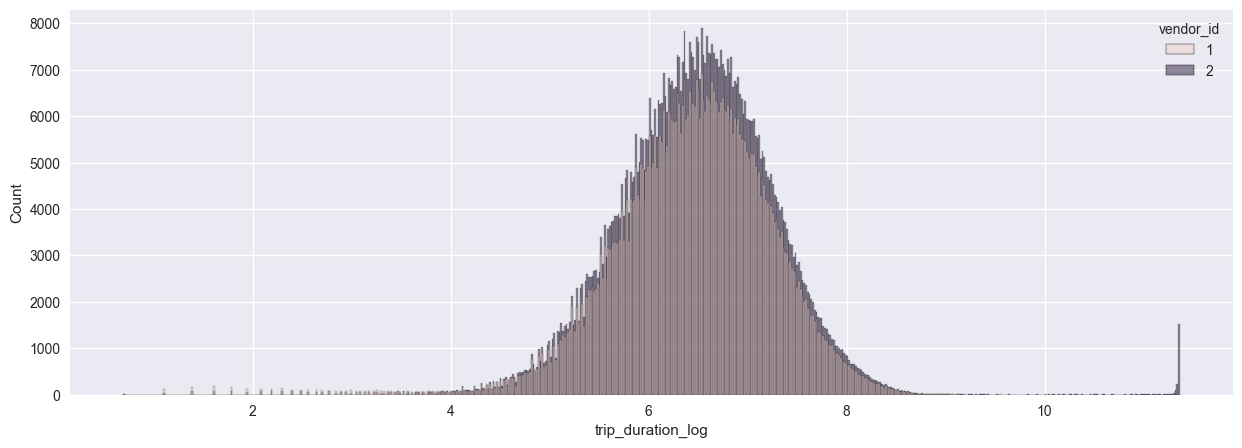

In [32]:
fig, axes = plt.subplots(1, 1, figsize=(15,5))
sns.histplot(x=taxi_data['trip_duration_log'], hue=taxi_data['vendor_id'])
ax.set_xlabel('Trip duration (log)')
ax.set_title('Histplot distribution');

Распределения в группах практически не отличаются, признак *vendor_id* не имеет значения при определении длительности поездки.

### 3.3 Длительность поездки в зависимости от признака отправки сообщения
Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (*trip_duration_log*) в зависимости от признака отправки сообщения поставщику (*store_and_fwd_flag*). 

Сравним два распределения между собой.

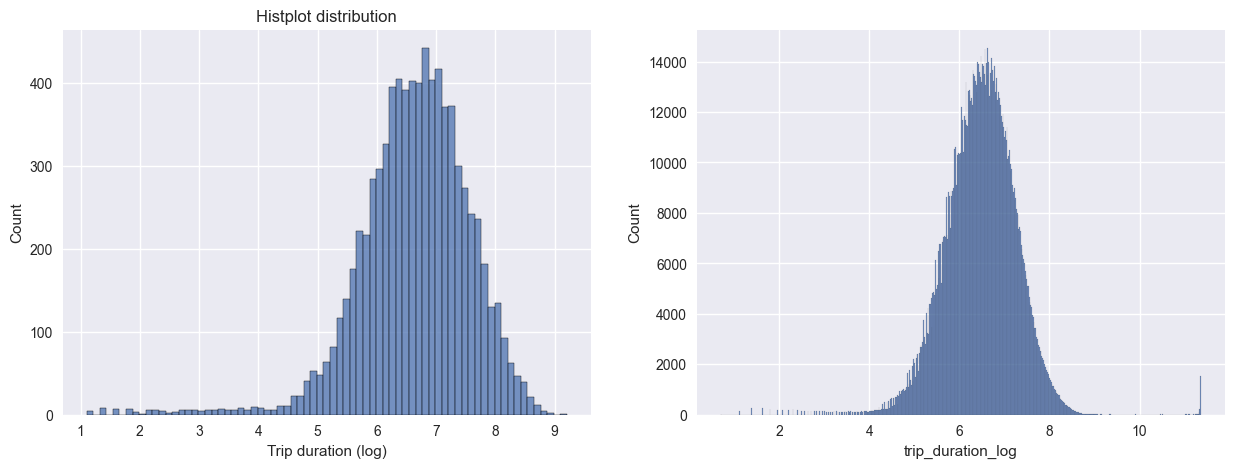

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(data=taxi_data[taxi_data['store_and_fwd_flag']=='Y'], x=taxi_data[taxi_data['store_and_fwd_flag']=='Y']['trip_duration_log'], ax=axes[0])
axes[0].set_xlabel('Trip duration (log)')
axes[0].set_title('Histplot distribution');
sns.histplot(data=taxi_data[taxi_data['store_and_fwd_flag']=='N'], x=taxi_data[taxi_data['store_and_fwd_flag']=='N']['trip_duration_log'], ax=axes[1]);

Распределения в группах значительно отличаются, признак *store_and_fwd_flag* имеет значение при определении длительности поездки.

### 3.4 Зависимость количества и длительности поездок от часа дня
Построим две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

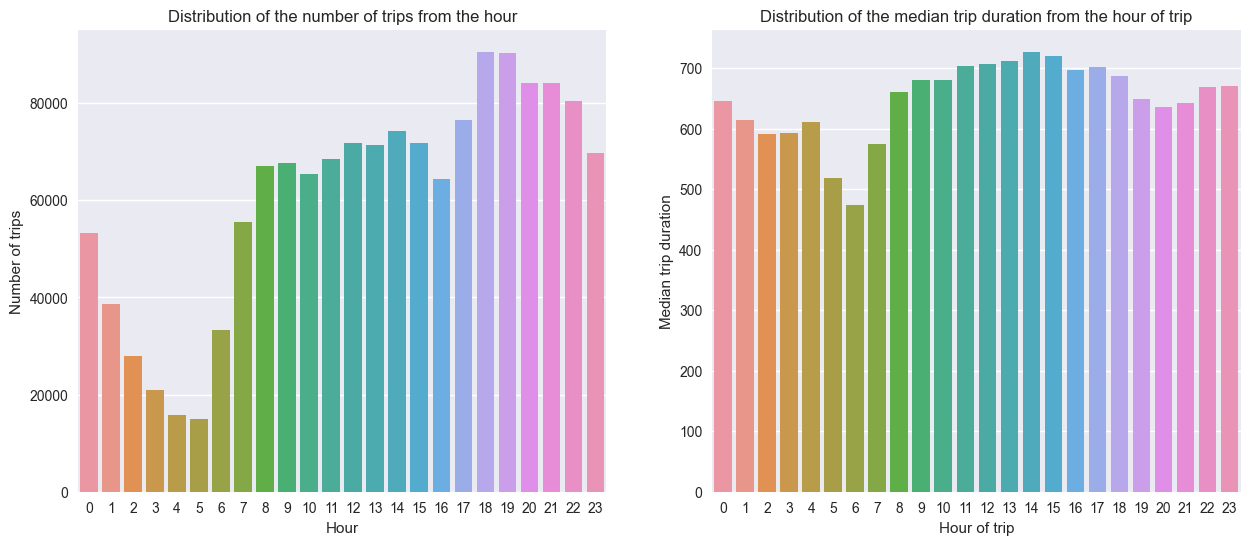

In [34]:
# Распределение количества поездок в зависимости от часа дня
trip_count_per_day = taxi_data.groupby(by='pickup_hour', as_index=False)['id'].count()
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(trip_count_per_day, x='pickup_hour', y='id', ax=axes[0])
axes[0].set_title('Distribution of the number of trips from the hour')
axes[0].set_ylabel('Number of trips')
axes[0].set_xlabel('Hour');

# Зависимость медианной длительности поездки от часа дня
trip_duration_per_hour = taxi_data.groupby(by='pickup_hour', as_index=False)['trip_duration'].median()
sns.barplot(trip_duration_per_hour, x='pickup_hour', y='trip_duration', ax=axes[1])
axes[1].set_title('Distribution of the median trip duration from the hour of trip')
axes[1].set_xlabel('Hour of trip')
axes[1].set_ylabel('Median trip duration');


На основе построенных графиков можно сделать следующие выводы:

* Реже всего заказывают такси с 00:00 до 06:00
* Пик медианной длительности поездки наблюдается в период с 11:00 до 18:00

### 3.5 Зависимость количства и длительности поездки от дня недели
Построим две визуализации:
* Распределение количества поездок в зависимости от дня недели;
* Зависимость медианной длительности поездки от дня недели.

In [35]:
taxi_data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_claster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')

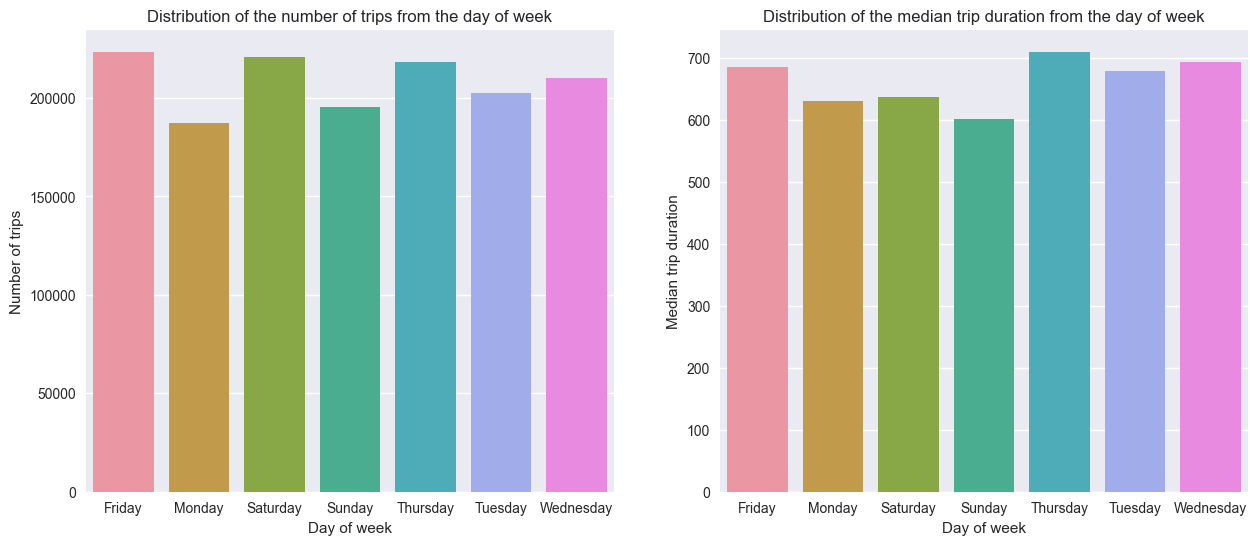

In [36]:
# Распределение количества поездок в зависимости от дня недели
trip_count_per_day = taxi_data.groupby(by='pickup_day_of_week', as_index=False)['id'].count()
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(trip_count_per_day, x='pickup_day_of_week', y='id', ax=axes[0])
axes[0].set_title('Distribution of the number of trips from the day of week')
axes[0].set_ylabel('Number of trips')
axes[0].set_xlabel('Day of week');

# Зависимость медианной длительности поездки от дня недели
trip_duration_per_hour = taxi_data.groupby(by='pickup_day_of_week', as_index=False)['trip_duration'].median()
sns.barplot(trip_duration_per_hour, x='pickup_day_of_week', y='trip_duration', ax=axes[1])
axes[1].set_title('Distribution of the median trip duration from the day of week')
axes[1].set_xlabel('Day of week')
axes[1].set_ylabel('Median trip duration');

На основе построенных графиков можно сделать выводы:
* Больше всего поездок совершается в пятницу
* Наименьшая медианная длительность поездки наблюдается в субботу

### 3.6 Длительность поездки от часа дня и дня недели
Посмотрим на обе временные характеристики одновременно. 

Построим сводную таблицу, по строкам которой отложены часы (*pickup_hour*), по столбцам - дни недели (*pickup_day_of_week*), а в ячейках - медианная длительность поездки (*trip_duration*). 

Визуализируем полученную сводную таблицу с помощью тепловой карты.

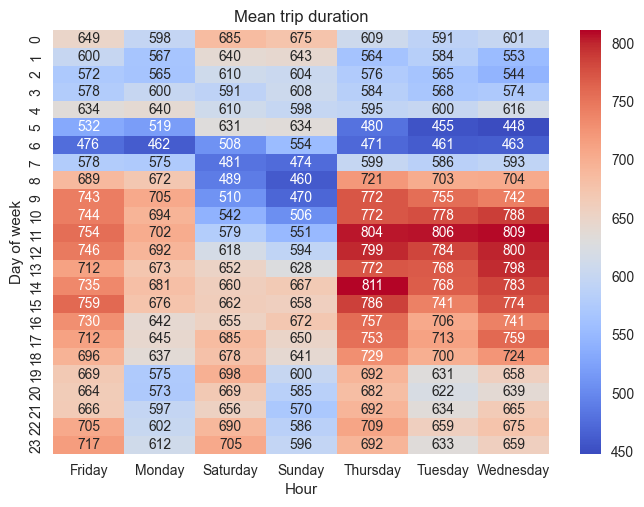

In [37]:
pivot_table = taxi_data.pivot_table(
    values='trip_duration',
    index='pickup_hour',
    columns='pickup_day_of_week',
    aggfunc='median'
)
heatmap = sns.heatmap(pivot_table, fmt='.0f', annot=True, cmap='coolwarm')
heatmap.set_xlabel('Hour')
heatmap.set_ylabel('Day of week')
heatmap.set_title('Mean trip duration');

Выводы:
* Самые продолжительные поездки (в медианном смысле) наблюдаются с понедельника по пятницу в промежутке с 8 до 18 часов.
* Наибольшая медианная длительность поездки наблюдалась в четверг в 14 часов дня.

### 3.7 Диагарммы географического положения точек начала и конца поездки
Построим две диаграммы рассеяния (*scatter*-диаграммы):
* первая будет иллюстрировать географическое расположение точек начала поездок (*pickup_longitude*, *pickup_latitude*) 
* вторая будет иллюстировать географическое расположение точек завершения поездок (*dropoff_longitude*, *dropoff_latitude*).

Для этого на диаграммах по оси абсцисс отложим широту (*longitude*), а по оси ординат - долготу (*latitude*). 
Включим в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавим следующие ограничения на границы осей абсцисс и ординат:
 
*city_long_border* = (-74.03, -73.75)

*city_lat_border* = (40.63, 40.85)

Добавим на диаграммы расцветку по десяти географическим кластерам (*geo_cluster*), которые мы сгенерировали ранее. 

h:\DataScience\programs\lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
h:\DataScience\programs\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


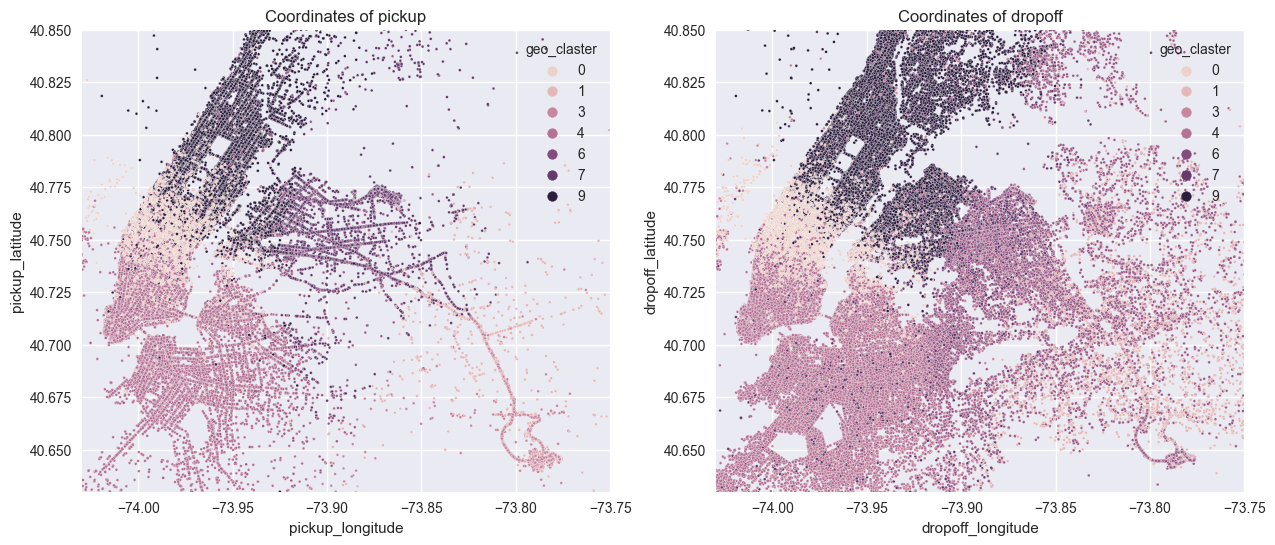

In [38]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.scatterplot(data=taxi_data,
                x='pickup_longitude',
                y='pickup_latitude',
                hue='geo_claster',
                s=4,
                ax=axes[0])
axes[0].set_xlim(city_long_border)
axes[0].set_ylim(city_lat_border)
axes[0].set_title('Coordinates of pickup')
sns.scatterplot(taxi_data,
                x='dropoff_longitude',
                y='dropoff_latitude',
                hue='geo_claster',
                s=4,
                ax=axes[1])
axes[1].set_xlim(city_long_border)
axes[1].set_ylim(city_lat_border)
axes[1].set_title('Coordinates of dropoff');


## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


Для удобства работы сделаем копию исходной таблицы с поездками:

In [40]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_claster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


### 4.1 Удаление неинформативных и избыточных признаков
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

* Признак *id* является уникальным для каждой поездки и не несёт полезной информации в определении её продолжительности
* Признак dropoff_datetime в обучающем наборе данных создает утечку данных. Это зафиксированное время остановки счётчика. Начиная поездку, мы никак не можем точно знать, когда она закончится, ведь мы как раз и пытаемся предсказать время окончания поездки

Исключим вышеуказанные признаки из исходной таблицы с данными

In [41]:
train_data.drop(['id', 'dropoff_datetime'], axis=1, inplace=True)
train_data.shape

(1458233, 25)

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [42]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### 4.2 Кодировка бинарных признаков
Закодируем признак *vendor_id* в таблице *train_data* таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 в противном случае.

Закодируем признак *store_and_fwd_flag* в таблице *train_data* таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 1 в противном случае.

In [43]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x==1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x=='N' else 1)

### 4.3 Кодирование номинальных категориальных признаков
Создадим таблицу *data_onehot* из закодированных однократным кодированием признаков *pickup_day_of_week*, *geo_cluster* и *events* в таблице *train_data* с помощью *OneHotEndoder* из библиотеки *sklearn*. Параметр *drop* выставим в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы *OneHotEncoder* получим безымянный *numpy*-массив, который нам будет необходимо преобразовать обратно в *DataFrame*, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа *OneHotEncoder* есть специальный метод `get_feature_names_out()`. Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

In [45]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(drop='first')
columns_to_change = ['pickup_day_of_week', 'geo_claster', 'events']
data_onehot = one_hot_encoder.fit_transform(train_data[columns_to_change]).toarray()
data_onehot

# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)

In [46]:
data_onehot.shape

(1458233, 18)

Добавим полученную таблицу с закодированными признаками:

In [47]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака *trip_duration* и его логарифмированной версии *trip_duration_log*:


In [48]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [49]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


## 5. Отбор и преобразование признаков
С помощью *SelectKBest* отберем 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуем по обучающей выборке, используя параметр `score_func` = f_regression.

Укажем признаки, которые вошли в список отобранных

In [50]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
selector = SelectKBest(score_func=f_regression, k=25)
selector.fit(X_train, y_train_log)

best_features = selector.get_feature_names_out()
print(best_features)
# в тренировочной и валидационной выборке оставляем отобранные 25 признаков
X_train = X_train[best_features]
X_valid = X_valid[best_features]

['vendor_id' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'store_and_fwd_flag' 'pickup_hour'
 'pickup_holiday' 'total_distance' 'total_travel_time' 'number_of_steps'
 'haversine_distance' 'temperature' 'pickup_day_of_week_Monday'
 'pickup_day_of_week_Saturday' 'pickup_day_of_week_Sunday'
 'pickup_day_of_week_Thursday' 'pickup_day_of_week_Tuesday'
 'pickup_day_of_week_Wednesday' 'geo_claster_1' 'geo_claster_3'
 'geo_claster_5' 'geo_claster_7' 'geo_claster_9']


Мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, поэтому заранее позаботимся о масштабировании факторов. 


### 5.1 Нормализация признаков
Нормализуем предикторы в обучающей и валидационной выборках с помощью *MinMaxScaler* из библиотеки *sklearn*. Обучение нормализатора производим на обучающей выборке, а трансформацию на обучающей и валидационной.

In [51]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# обучаем нормализатор на обучающей выборке
scaler.fit(X_train)
# применяем трансформацию на обучающей и валидационной выборке
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

## 6. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### 6.1 Построение модели линейной регрессии
Построим модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). Все параметры оставляем по умолчанию.

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках.

In [53]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_log)
y_pred_train = lr.predict(X_train_scaled)
y_pred_valid = lr.predict(X_valid_scaled)
rmsle_train = metrics.mean_squared_error(y_train_log, y_pred_train, squared=False)
rmsle_valid = metrics.mean_squared_error(y_valid_log, y_pred_valid, squared=False)
print(f'RMSLE на тренировочной выборке: {rmsle_train.round(2)}')
print(f'RMSLE на валидационной выборке: {rmsle_valid.round(2)}')

RMSLE на тренировочной выборке: 0.54
RMSLE на валидационной выборке: 0.54


### 6.2 Построение модели полиномиальной регрессии
Сгенерируем полиномиальные признаки 2-ой степени с помощью *PolynomialFeatures* из библиотеки *sklearn*. Параметр `include_bias` выставим в значение False.

Построим модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). Все параметры оставим по умолчанию.

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках. 

In [54]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_train_scaled)

In [55]:
lr_poly = LinearRegression()
lr_poly.fit(X_poly, y_train_log)
y_pred_train = lr_poly.predict(X_train_scaled)
y_pred_valid = lr_poly.predict(X_valid_scaled)
rmsle_train = metrics.mean_squared_error(y_train_log, y_pred_train, squared=False)
rmsle_valid = metrics.mean_squared_error(y_valid_log, y_pred_valid, squared=False)
print(f'RMSLE на тренировочной выборке: {rmsle_train.round(2)}')
print(f'RMSLE на валидационной выборке: {rmsle_valid.round(2)}')

### 6.3 Модель дерева решений
Построим модель дерева решений (*DecisionTreeRegressor*) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). Все параметры оставим по умолчанию. 

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках.

In [57]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train_log)
y_pred_train = dt.predict(X_train_scaled)
y_pred_valid = dt.predict(X_valid_scaled)
rmsle_train = metrics.mean_squared_error(y_train_log, y_pred_train, squared=False)
rmsle_valid = metrics.mean_squared_error(y_valid_log, y_pred_valid, squared=False)
print(f'RMSLE на тренировочной выборке: {rmsle_train.round(2)}')
print(f'RMSLE на валидационной выборке: {rmsle_valid.round(2)}')

RMSLE на тренировочной выборке: 0.0
RMSLE на валидационной выборке: 0.57


У модели наблюдаются признаки переобучения

### 6.4 Дерево решений с подбором параметров
Переберем все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

`max_depths` = range(7, 20)

Построим линейные графики изменения метрики *RMSE* на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

In [58]:
max_depth = range(7,20)
rmsle_train_list = []
rmsle_test_list = []
for depth in max_depth:
    dt = DecisionTreeRegressor(random_state=42, max_depth=depth)
    dt.fit(X_train_scaled, y_train_log)
    y_pred_train = dt.predict(X_train_scaled)
    y_pred_valid = dt.predict(X_valid_scaled)
    rmsle_train = metrics.mean_squared_error(y_train_log, y_pred_train, squared=False)
    rmsle_train_list.append(rmsle_train)
    rmsle_valid = metrics.mean_squared_error(y_valid_log, y_pred_valid, squared=False)
    rmsle_test_list.append(rmsle_valid)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


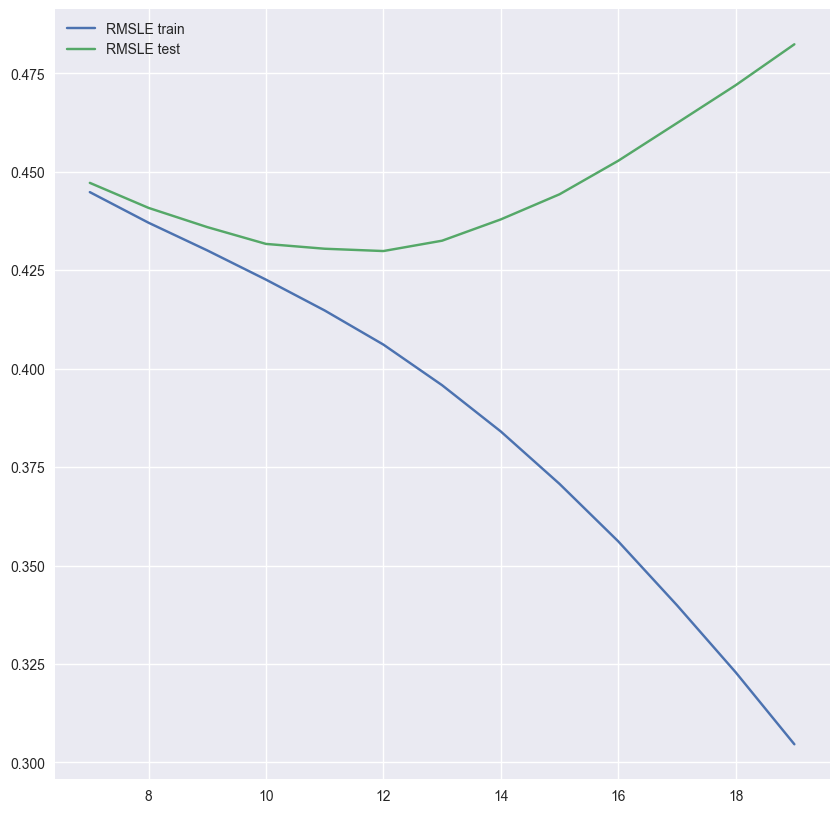

In [80]:
# построение графиков
sns.lineplot(x=max_depth, y=rmsle_train_list, label='RMSLE train')
sns.lineplot(x=max_depth, y=rmsle_test_list, label='RMSLE valid')
ax.set_title('Зависимость метрики RMSLE от глубины дерева решений')
ax.legend();

Оптимальное значение максимальной глубины дерева, для которой наблюдается минимальное значение *RMSLE* на обучающей выборке, но при этом еще не наблюдаетсся переобучение (валидационная кривая еще не начинает возрастать) равно 12.

Вычислим значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной 12.

In [60]:
dt = DecisionTreeRegressor(random_state=42, max_depth=12)
dt.fit(X_train_scaled, y_train_log)
y_pred_train = dt.predict(X_train_scaled)
y_pred_valid = dt.predict(X_valid_scaled)
rmsle_train = metrics.mean_squared_error(y_train_log, y_pred_train, squared=False)
rmsle_valid = metrics.mean_squared_error(y_valid_log, y_pred_valid, squared=False)
print(f'RMSLE на тренировочной выборке: {rmsle_train.round(2)}')
print(f'RMSLE на валидационной выборке: {rmsle_valid.round(2)}')

RMSLE на тренировочной выборке: 0.41
RMSLE на валидационной выборке: 0.43


## 7. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к ансамблевым алгоритмам. 

### 7.1 Случайный лес

Построим модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). В качестве гиперпараметров укажем следующие:
* *n_estimators*=200,
* *max_depth*=12,
* *criterion*='squared_error',
* *min_samples_split*=20,
* *random_state*=42

Для полученной модели рассчитаем метрику *RMSLE* на тренировочной и валидационной выборках.

In [61]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200,
                           max_depth=12,
                           criterion='squared_error',
                           min_samples_split=20,
                           random_state=42)
# обучение модели
rf.fit(X_train_scaled, y_train_log)
# предсказание на тренировочной и валидационной выборках
y_pred_train = rf.predict(X_train_scaled)
y_pred_valid = rf.predict(X_valid_scaled)
# расчет метрики RMSLE на тренировочной и валидационной выборках
rmsle_train = metrics.mean_squared_error(y_train_log, y_pred_train, squared=False)
rmsle_valid = metrics.mean_squared_error(y_valid_log, y_pred_valid, squared=False)
print(f'RMSLE на тренировочной выборке: {rmsle_train.round(2)}')
print(f'RMSLE на валидационной выборке: {rmsle_valid.round(2)}')

### 7.2. Градиентный бустинг
Построим модель градиентного бустинга над деревьями решений (*GradientBoostingRegressor*) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). В качестве гиперпараметров укажем следующие:
* *learning_rate*=0.5,
* *n_estimators*=100,
* *max_depth*=6, 
* *min_samples_split*=30,
* *random_state*=42

Для полученной модели рассчитаем метрику *RMSLE* на тренировочной и валидационной выборках.

In [62]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(learning_rate=0.5,
                               n_estimators=100,
                               max_depth=6,
                               min_samples_split=30,
                               random_state=42,
                               verbose=True)
# обучение модели
gb.fit(X_train_scaled, y_train_log)
# предсказание на тренировочной и валидационной выборках
y_pred_train = gb.predict(X_train_scaled)
y_pred_valid = gb.predict(X_valid_scaled)
# расчет метрики RMSLE на тренировочной и валидационной выборках
rmsle_train = metrics.mean_squared_error(y_train_log, y_pred_train, squared=False)
rmsle_valid = metrics.mean_squared_error(y_valid_log, y_pred_valid, squared=False)
print(f'RMSLE на тренировочной выборке: {rmsle_train.round(2)}')
print(f'RMSLE на валидационной выборке: {rmsle_valid.round(2)}')

      Iter       Train Loss   Remaining Time 
         1           0.3110           17.29m
         2           0.2247           16.92m
         3           0.1987           16.53m
         4           0.1875           16.31m
         5           0.1821           16.13m
         6           0.1789           15.92m
         7           0.1742           15.82m
         8           0.1721           15.58m
         9           0.1705           15.34m
        10           0.1694           15.23m
        20           0.1585           13.31m
        30           0.1532           11.61m
        40           0.1500            9.88m
        50           0.1468            8.13m
        60           0.1439            6.45m
        70           0.1421            4.82m
        80           0.1402            3.22m
        90           0.1383            1.61m
       100           0.1371            0.00s
RMSLE на тренировочной выборке: 0.37
RMSLE на валидационной выборке: 0.39


Градиентный бустинг над деревьями решений показал наилучший результат (наименьшее значение RMSLE на валидационной выборке)

### 7.3 Значимость факторов
Построим столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажем топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.

<AxesSubplot: >

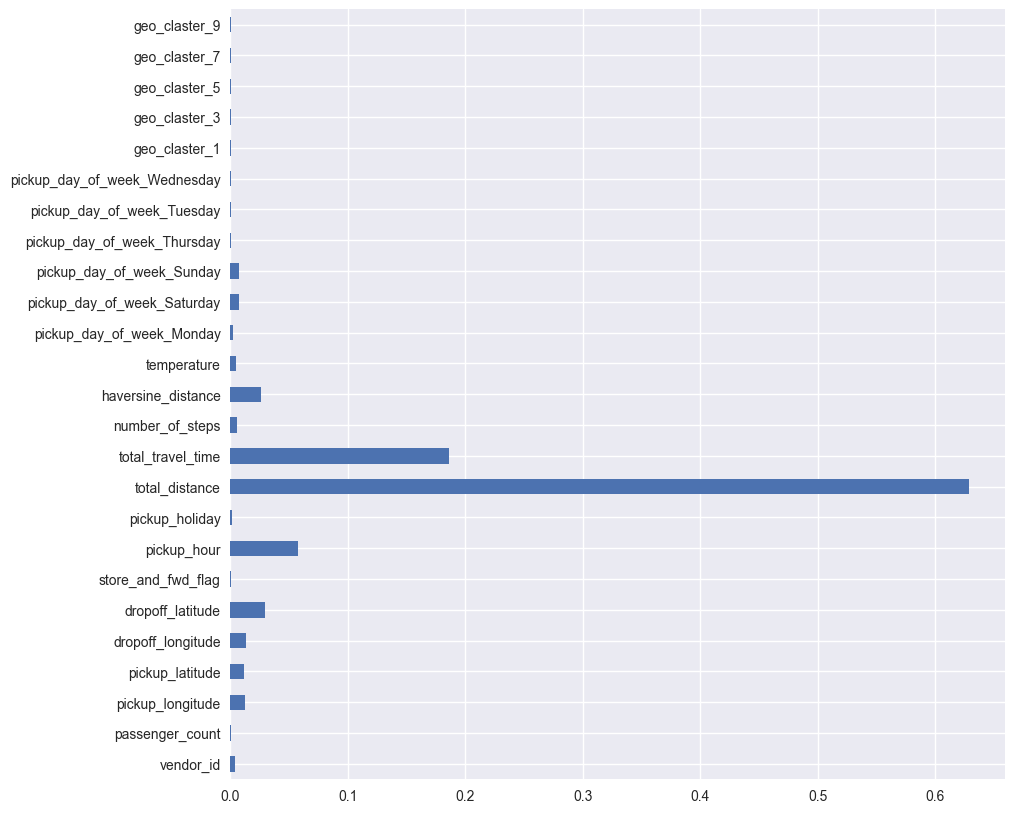

In [63]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(gb.feature_importances_, index=X_train.columns)
feat_importances.plot(kind='barh')

Топ-3 факторов, наиболее значимых для предсказания целевого признака (длительности поездки) в логарифмическом масштабе:
* total_distance
* total_travel_time
* pickup_hour

### 7.4 Расчет MeAE
Для лучшей из построенных моделей рассчитаем медианную абсолютную ошибку (MeAE - в sklearn функция *median_absolute_error*) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведем в минуты и округлим до десятых.

In [64]:
# расчет метрики MeAE с переводом логарифмированных величин обратно в нормальные
meae = metrics.median_absolute_error(np.exp(y_valid_log)-1, np.exp(y_pred_valid)-1)
print(f'Медианная абсолютная ошибка на валидационных данных (в секундах): {round(meae)}')
print(f'Медианная абсолютная ошибка на валидационных данных (в минутах): {round(meae/60, 2)}')

Медианная абсолютная ошибка на валидационных данных (в секундах): 110
Медианная абсолютная ошибка на валидационных данных (в минутах): 1.83


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [65]:
test_data = pd.read_csv("data/test.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv")
test_id = test_data['id']

In [66]:
test_data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [67]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)

h:\DataScience\programs\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [68]:
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудем перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как сформируем предсказание длительности поездок на тестовой выборке ннам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:

In [69]:
# предсказание
y_test_predict = np.exp(gb.predict(X_test_scaled)) - 1
y_test_predict

array([ 877.59616254,  551.42272252,  408.43598939, ..., 1668.59009784,
       1925.19202672, 1204.56599994])

In [70]:
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

### **В качестве бонуса**

В завершение по ансамблевым попробуем улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.

In [72]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [73]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [74]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42218	valid-rmse:5.42190
[10]	train-rmse:1.93575	valid-rmse:1.93569
[20]	train-rmse:0.78507	valid-rmse:0.78592
[30]	train-rmse:0.47892	valid-rmse:0.48093
[40]	train-rmse:0.42050	valid-rmse:0.42312
[50]	train-rmse:0.40890	valid-rmse:0.41187
[60]	train-rmse:0.40421	valid-rmse:0.40761
[70]	train-rmse:0.40130	valid-rmse:0.40512
[80]	train-rmse:0.39910	valid-rmse:0.40326
[90]	train-rmse:0.39715	valid-rmse:0.40159
[100]	train-rmse:0.39544	valid-rmse:0.40017
[110]	train-rmse:0.39415	valid-rmse:0.39928
[120]	train-rmse:0.39297	valid-rmse:0.39832
[130]	train-rmse:0.39152	valid-rmse:0.39718
[140]	train-rmse:0.39054	valid-rmse:0.39654
[150]	train-rmse:0.38924	valid-rmse:0.39552
[160]	train-rmse:0.38870	valid-rmse:0.39516
[170]	train-rmse:0.38805	valid-rmse:0.39483
[180]	train-rmse:0.38737	valid-rmse:0.39443
[190]	train-rmse:0.38648	valid-rmse:0.39376
[200]	train-rmse:0.38582	valid-rmse:0.39334
[210]	train-rmse:0.38518	valid-rmse:0.39316
[220]	train-rmse:0.38468	valid-rmse:0.39291

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [75]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39078


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

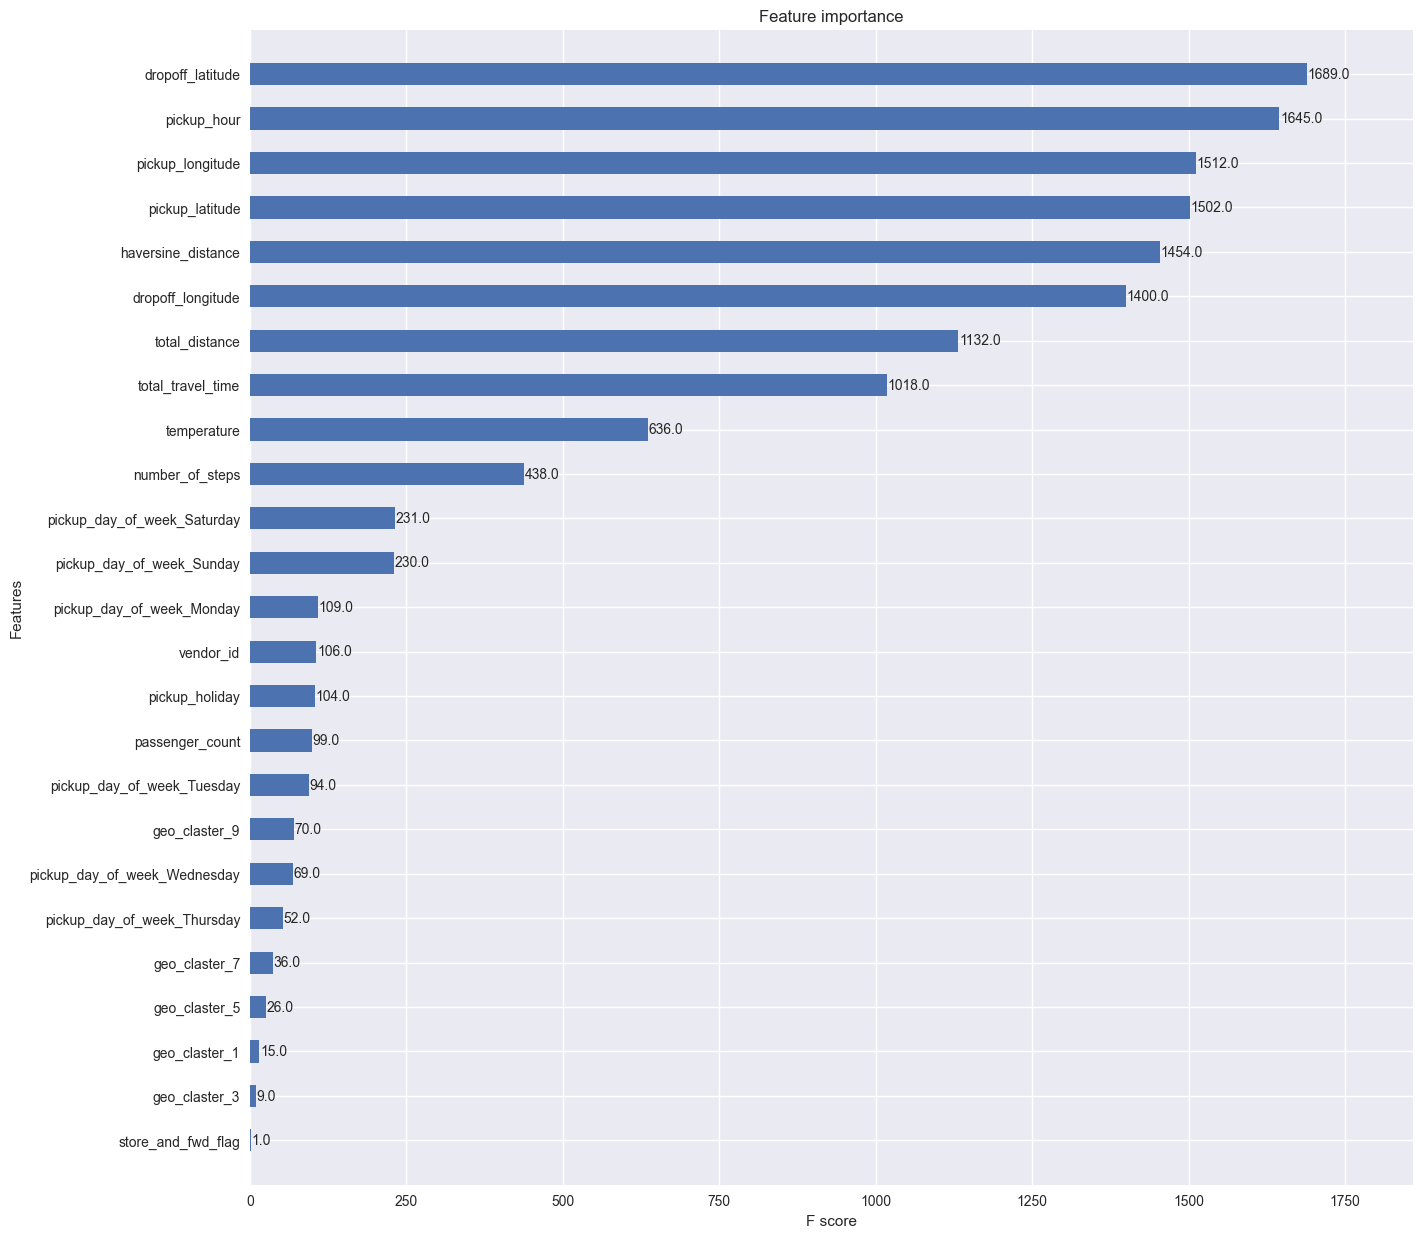

In [76]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)